## CS441: Applied ML - HW 2

### Part 1: Model Complexity and Tree-based Regressors

Include all the code for Part 1 in this section

In [11]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  drive.mount('/content/drive')
  datadir = "/content/drive/My Drive/Spring2023/cs441/hw2/" # "/content/drive/My Drive/CS441/hw1/"
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target temperature
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()

# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

Mounted at /content/drive


In [16]:
# to plot the errors
def plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err):
  plt.figure(figsize=(15,15))
  plt.semilogx(max_depths, tree_train_err, 'r.--',label='tree train')
  plt.semilogx(max_depths, tree_val_err, 'r.-', label='tree val')
  plt.semilogx(max_depths, rf_train_err, 'g.--',label='RF train')
  plt.semilogx(max_depths, rf_val_err, 'g.-', label='RF val')
  plt.semilogx(max_depths, bt_train_err, 'b.--',label='BT train')
  plt.semilogx(max_depths, bt_val_err, 'b.-', label='BT val')
  plt.ylabel('RMSE Error')
  plt.xlabel('Max Tree Depth')
  plt.xticks(max_depths, max_depths)
  plt.legend()
  plt.rcParams.update({'font.size': 20})
  plt.show()

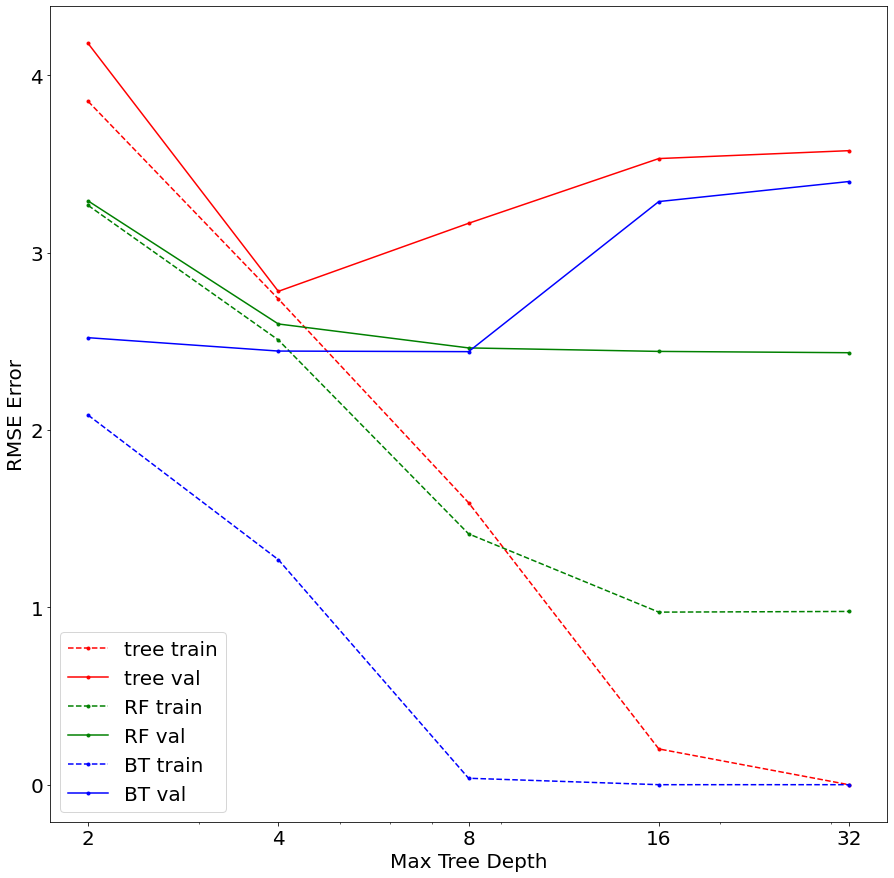

In [22]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

max_depths = [2,4,8,16,32]
tree_train_err = []
tree_val_err = []
rf_train_err = []
rf_val_err = []
bt_train_err = []
bt_val_err = []

# usage examples

for max_depth in max_depths:
  model = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
  model.fit(x_train, y_train)
  tree_train = model.predict(x_train)
  tree_train_err.append(mean_squared_error(y_train, tree_train, squared=False))
  tree_val = model.predict(x_val)
  tree_val_err.append(mean_squared_error(y_val, tree_val, squared=False))

for max_depth in max_depths:
  model = RandomForestRegressor(random_state=0, max_depth=max_depth, max_features=1/3)
  model.fit(x_train, y_train)
  rf_train = model.predict(x_train)
  rf_train_err.append(mean_squared_error(y_train, rf_train, squared=False))
  rf_val = model.predict(x_val)
  rf_val_err.append(mean_squared_error(y_val, rf_val, squared=False))


for max_depth in max_depths:
  model = GradientBoostingRegressor(random_state=0, max_depth=max_depth)
  model.fit(x_train, y_train)
  bt_train = model.predict(x_train)
  bt_train_err.append(mean_squared_error(y_train, bt_train, squared=False))
  bt_val = model.predict(x_val)
  bt_val_err.append(mean_squared_error(y_val, bt_val, squared=False))

plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err)

### Part 2: MLPs with MNIST

Include all the code for Part 2 in this section

In [24]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import torch

# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

# displays a set of mnist images
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

In [25]:
(x_train, y_train), (x_validation, y_validation), (x_test, y_test), train_indices = load_mnist()

In [26]:
# Sets device to "cuda" if a GPU is available  (in Colabs, enable GPU by Edit->Notebook Settings-->Hardware Accelerator=GPU)
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [27]:
import numpy as np
def display_error_curves(num_epochs, training_losses, validation_losses):
  """
  Plots the training and validation loss curves
  """
  plt.plot(np.arange(num_epochs), training_losses, label="Training Loss")
  plt.plot(np.arange(num_epochs), validation_losses, label="Validation Loss")

  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  
  # Display the plot
  plt.legend(loc='best')
  plt.show()

In [28]:
import torch
# Define the model
class MLP(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    # Needs code here
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(input_size, hidden_size),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden_size, output_size),
      torch.nn.Sigmoid()
    )
      
  def forward(self, x):
    # Needs code here
      return self.layers(x)

Train loss = 1.4709759915161134, Val loss = 1.488089176940918


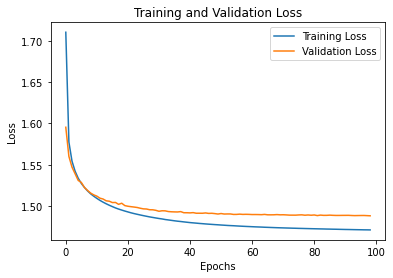

Train loss = 1.5969673653793335, Val loss = 1.5939380004882813


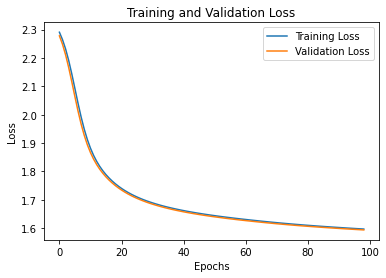

Train loss = 1.907959024734497, Val loss = 1.9034468591690064


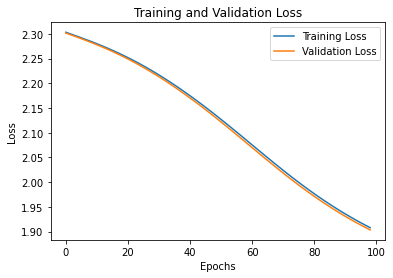

In [35]:
import numpy as np
import torch
import matplotlib.pyplot as plt


# set the hyperparameters

lr = 1
batch_size = 256
num_epochs = 100

input_size = 784
hidden_size = 256
output_size = 10

# create data loaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train)), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_validation), torch.from_numpy(y_validation)), batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_test.numpy()), torch.from_numpy(y_test.numpy())), batch_size=batch_size)

# create the model and optimizer
model = MLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# train the model
train_losses = []
val_losses = []
for epoch in range(1, num_epochs):
  model.train()
  train_loss = 0
  for batch, (x_tr, y_tr) in enumerate(train_loader):
    optimizer.zero_grad()
    y_pred = model(x_tr.float())
    loss = loss_fn(y_pred, y_tr.long())
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * len(x_tr)
  train_loss /= len(train_loader.dataset)
  train_losses.append(train_loss)

  model.eval()
  val_loss = 0
  with torch.no_grad():
    for x_val, y_val in val_loader:
      y_val_pred = model(x_val.float())
      loss = loss_fn(y_val_pred, y_val.long())
      val_loss += loss.item() * len(x_val)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

print(f"Train loss = {train_losses[-1]}, Val loss = {val_losses[-1]}")
display_error_curves(epoch, train_losses, val_losses)

# model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for x_tr, y_tr in train_loader:
    y_tr_pred = model(x_tr.float())
    _, predicted = torch.max(y_tr_pred.data, 1)
    total += y_tr.size(0)
    correct += (predicted == y_tr).sum().item()
  tr_error = (1 - correct / total) * 100
  tr_acc = 100 * correct / total

print(f"Train accuracy: {tr_acc}%")
print(f"Train error = {tr_error}")

# model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for x_val, y_val in val_loader:
    y_val_pred = model(x_val.float())
    _, predicted = torch.max(y_val_pred.data, 1)
    total += y_val.size(0)
    correct += (predicted == y_val).sum().item()
  val_error = (1 - correct / total) * 100
  val_acc = 100 * correct / total

print(f"Validation accuracy: {val_acc}%")
print(f"Validation error = {val_error}")

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for x_test, y_test in test_loader:
    y_test_pred = model(x_test.float())
    _, predicted = torch.max(y_test_pred.data, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()
  test_error = (1 - correct / total) * 100
  test_acc = 100 * correct / total

print(f"Test accuracy: {test_acc}%")
print(f"Test error: {test_error}")


In [ ]:
# experiments code
print(device) # make sure you're using GPU instance
torch.manual_seed(0) # to avoid randomness, but if you wanted to create an ensemble, you should not use a manual seed

## Part 3: Predicting Penguin Species

Include all your code for part 3 in this section.  

In [1]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#styling preferences for sns
sns.set_style('whitegrid')
sns.set_context('poster')
drive.mount('/content/gdrive/')
datadir = "/content/gdrive/My Drive/Spring2023/cs441/hw2/" 
df_penguins = pd.read_csv(datadir + 'penguins_size.csv')
df_penguins.head(10)

def get_penguin_xy(df_penguins):
  data = np.array(df_penguins[['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']])
  y = df_penguins['species']
  ui = np.unique(data[:,0])
  us = np.unique(data[:,-1])
  X = np.zeros((len(y), 10))
  for i in range(len(y)):
    f = 0
    for j in range(len(ui)):
      if data[i, f]==ui[j]:
        X[i, f+j] = 1
    X[i, 3:7] = data[i, 1:5]
    for j in range(len(us)):
      if data[i, 5]==us[j]:
        X[i, f+j] = 1
  feature_names = ['island_biscoe', 'island_dream', 'island_torgersen', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_female', 'sex_male', 'sex_unknown']
  X = pd.DataFrame(X, columns=feature_names)
  return(X, y, feature_names, np.unique(y))


Mounted at /content/gdrive/


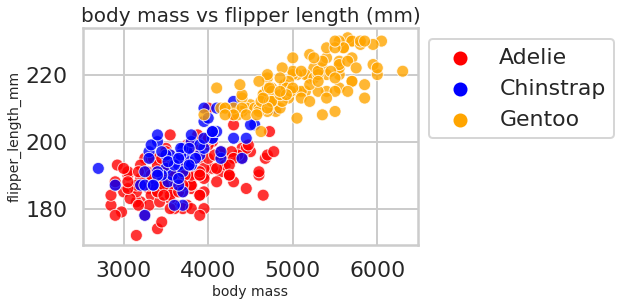

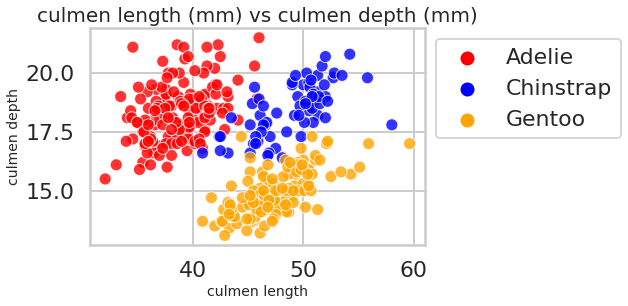

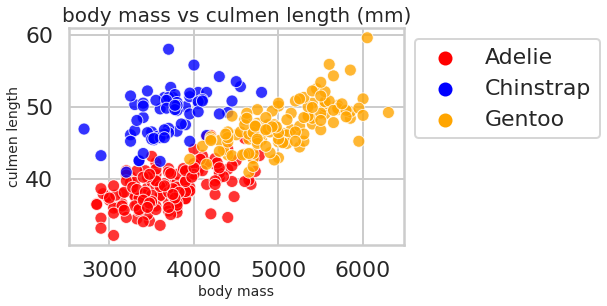

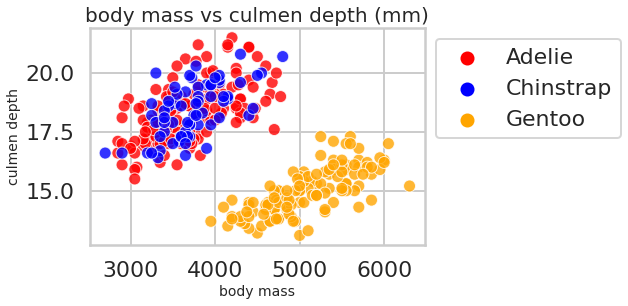

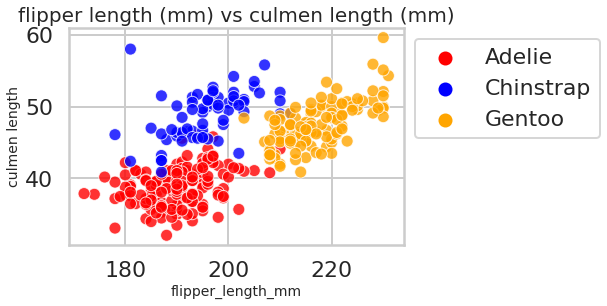

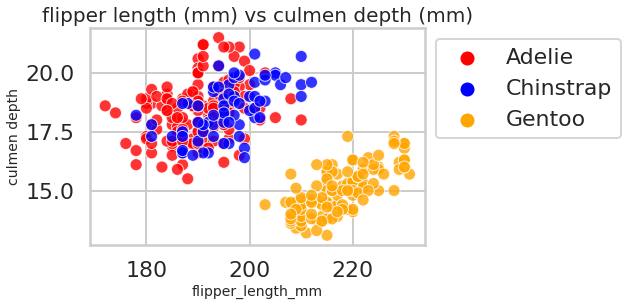

In [2]:
palette = ["red", "blue", "orange"]

# https://seaborn.pydata.org/generated/seaborn.scatterplot.html

# body mass vs flipper length
sns.scatterplot(data=df_penguins, x = 'body_mass_g', y = 'flipper_length_mm', hue = 'species', palette=palette, alpha=0.8)
plt.xlabel('body mass', fontsize=14)
plt.ylabel('flipper_length_mm', fontsize=14)
plt.title('body mass vs flipper length (mm)', fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

# culmen length vs culmen depth
sns.scatterplot(data=df_penguins, x = 'culmen_length_mm', y = 'culmen_depth_mm', hue = 'species', palette=palette, alpha=0.8)
plt.xlabel('culmen length', fontsize=14)
plt.ylabel('culmen depth', fontsize=14)
plt.title('culmen length (mm) vs culmen depth (mm)', fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

# body mass vs culmen length
sns.scatterplot(data=df_penguins, x = 'body_mass_g', y = 'culmen_length_mm', hue = 'species', palette=palette, alpha=0.8)
plt.xlabel('body mass', fontsize=14)
plt.ylabel('culmen length', fontsize=14)
plt.title('body mass vs culmen length (mm)', fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

# body mass vs culmen depth
sns.scatterplot(data=df_penguins, x = 'body_mass_g', y = 'culmen_depth_mm', hue = 'species', palette=palette, alpha=0.8)
plt.xlabel('body mass', fontsize=14)
plt.ylabel('culmen depth', fontsize=14)
plt.title('body mass vs culmen depth (mm)', fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

# flipper length vs culmen length
sns.scatterplot(data=df_penguins, x = 'flipper_length_mm', y = 'culmen_length_mm', hue = 'species', palette=palette, alpha=0.8)
plt.xlabel('flipper_length_mm', fontsize=14)
plt.ylabel('culmen length', fontsize=14)
plt.title('flipper length (mm) vs culmen length (mm)', fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

# flipper length vs culmen depth
sns.scatterplot(data=df_penguins, x = 'flipper_length_mm', y = 'culmen_depth_mm', hue = 'species', palette=palette, alpha=0.8)
plt.xlabel('flipper_length_mm', fontsize=14)
plt.ylabel('culmen depth', fontsize=14)
plt.title('flipper length (mm) vs culmen depth (mm)', fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

# Gentoo
# flipper length the longest and body mass the heaviest
# culmen length is around the middle and culmen depth the shortest
# culmen length is around the middle and body mass the heaviest
# 

Accuracy: 96.48%


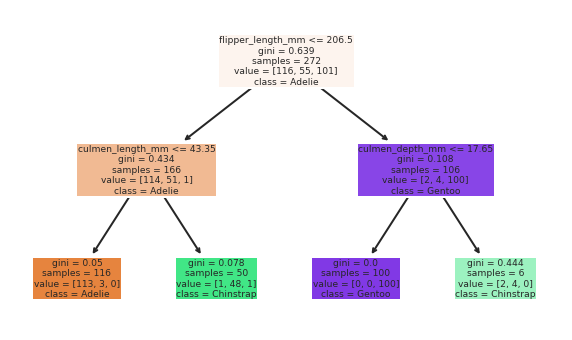

In [3]:
# design a classification model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Get the preprocessed data
X, y, feature_names, class_names = get_penguin_xy(df_penguins)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth=2, criterion='gini')

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

plt.figure(figsize=(10,6))
plot_tree(model, feature_names=feature_names, class_names=class_names, filled=True)

acc = model.score(X, y)
print('Accuracy: {:.2f}%'.format(acc*100))

In [4]:
# design a classification model with more than 99% accuracy on 5-fold cross-validation accuracy
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

# Get the preprocessed data
X, y, feature_names, class_names = get_penguin_xy(df_penguins)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(solver='liblinear', random_state=0)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

scores = cross_val_score(model, X, y, cv=5)
print('CV Accuracy: {:.4f}%'.format(scores.mean()*100))


CV Accuracy: 99.7059%


## Part 4: Stretch Goals
Include any new code needed for Part 4 here

In [7]:
import torch
class PositionalEncodingNet(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(PositionalEncodingNet, self).__init__()
    self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = torch.nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    out = torch.sin(self.fc1(x))
    out = torch.sin(self.fc2(out))
    out = torch.sigmoid(self.fc3(out))
    return out

class MLPNet(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(MLPNet, self).__init__()
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(input_dim, hidden_dim),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden_dim, hidden_dim),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden_dim, hidden_dim),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden_dim, output_dim),
      torch.nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


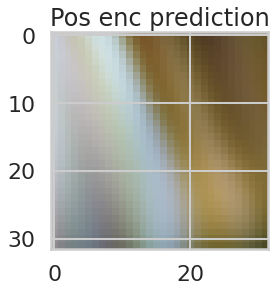

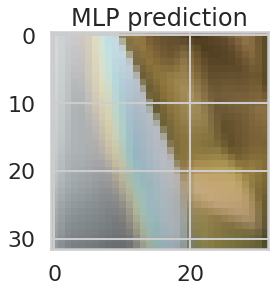

In [13]:
import torch
import numpy as np
from PIL import Image
from google.colab import drive

drive.mount('/content/drive/')
img_dir = "/content/drive/My Drive/Spring2023/cs441/hw2/"
img_path = img_dir + "scotland_photo.jpg" 
img = Image.open(img_path)
img = img.resize((32, 32), Image.ANTIALIAS)

def positional_encoding(x, y, hidden_dim):
  angles_x = x.unsqueeze(-1) / torch.pow(10000, torch.arange(0, hidden_dim, 2).float() / hidden_dim)
  angles_y = y.unsqueeze(-1) / torch.pow(10000, (torch.arange(0, hidden_dim, 2).float() + 1) / hidden_dim)
  angles = torch.cat([angles_x, angles_y], dim=-1)
  pos_enc = torch.sin(angles)
  return pos_enc

data = np.zeros((32, 32, 2))
labels = np.zeros((32, 32, 3))
for i in range(32):
  for j in range(32):
    data[i][j][0] = i / 31
    data[i][j][1] = j / 31
    labels[i][j][0] = img.getpixel((i, j))[0] / 255
    labels[i][j][1] = img.getpixel((i, j))[1] / 255
    labels[i][j][2] = img.getpixel((i, j))[2] / 255

data = torch.tensor(data, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# Train the positional encoding network
pos_enc_net = PositionalEncodingNet(256, 256, 3)
pos_enc_optimizer = torch.optim.Adam(pos_enc_net.parameters(), lr=0.001)
pos_enc_loss_fn = torch.nn.MSELoss()
pos_enc_epochs = 1000

for epoch in range(pos_enc_epochs):
  pos_enc_optimizer.zero_grad()
  pos_enc_data = positional_encoding(data[..., 0], data[..., 1], 256)
  pos_enc_pred = pos_enc_net(pos_enc_data)
  pos_enc_loss = pos_enc_loss_fn(pos_enc_pred, labels)
  pos_enc_loss.backward()
  pos_enc_optimizer.step()
  # if (epoch + 1) % 100 == 0:
  #   print(f'Epoch [{epoch + 1}/{pos_enc_epochs}], Loss: {pos_enc_loss.item():.4f}')

# Train the MLP network
mlp_net = MLPNet(2, 256, 3)
mlp_optimizer = torch.optim.Adam(mlp_net.parameters(), lr=0.001)
mlp_loss_fn = torch.nn.MSELoss()
mlp_epochs = 1000

for epoch in range(mlp_epochs):
  mlp_optimizer.zero_grad()
  mlp_pred = mlp_net(data.reshape(-1, 2))
  mlp_loss = mlp_loss_fn(mlp_pred, labels.reshape(-1, 3))
  mlp_loss.backward()
  mlp_optimizer.step()
  # if (epoch + 1) % 100 == 0:
  #     print(f'Epoch [{epoch + 1}/{mlp_epochs}], Loss: {mlp_loss.item():.4f}')


# Generate images using the positional encoding network
pos_enc_data = torch.zeros((1024, 2))
for i in range(32):
  for j in range(32):
    pos_enc_data[i * 32 + j][0] = i / 31
    pos_enc_data[i * 32 + j][1] = j / 31

pos_enc_data = positional_encoding(pos_enc_data[:, 0], pos_enc_data[:, 1], 256)
pos_enc_pred = pos_enc_net(pos_enc_data)
pos_enc_pred = pos_enc_pred.reshape(32, 32, 3)
pos_enc_pred = np.uint8(pos_enc_pred.detach().numpy() * 255)
pos_enc_image = Image.fromarray(pos_enc_pred)
plt.imshow(pos_enc_image)
plt.title("Pos enc prediction")
plt.show()
# pos_enc_image.show()

# Generate images using the MLP network
mlp_pred = mlp_net(data.reshape(-1, 2))
mlp_pred = mlp_pred.reshape(32, 32, 3)
mlp_pred = np.uint8(mlp_pred.detach().numpy() * 255)
mlp_image = Image.fromarray(mlp_pred)
plt.imshow(mlp_image)
plt.title("MLP prediction")
plt.show()
# mlp_image.show()
